<a href="https://colab.research.google.com/github/lukes72/USYD/blob/main/assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP5329 - Deep Learning
## Tutorial 2 - Multilayer Neural Network

**Semester 1, 2022**

**Objectives:**

* To understand the multi-layer perceptron.
* To become familiar with backpropagation.



## Loading the packages

In [ ]:
import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation

 ## The Dataset
The following script allows you to create a 2D dataset by using the mouse. The left click adds points belonging to class A (blue), and the right click adds points belonging to class B (red). You can create as many points as you desire. The final dataset will contain hence three values per point: x coordinate [-1,1], y coordinate [-1,1] and the class {1,-1}.

In [ ]:
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load dataset
train_X = np.load('/content/drive/MyDrive/COMP5329/assignment1 data/train_data.npy', encoding='bytes')
print("train X shape: " + str(train_X.shape))
train_y_raw = np.load('/content/drive/MyDrive/COMP5329/assignment1 data/train_label.npy', encoding='bytes')
print("train y shape: " + str(train_y_raw.shape))

# check label possible values
print(set(train_y_raw.flatten()))

# transform labels to one hot
train_y = np.zeros(shape = (train_y_raw.shape[0], np.max(train_y_raw) + 1))

# fill up the transformed label
for idx, i in enumerate(train_y_raw):
  train_y[idx][i] = 1

# verify one-hot labels
print(train_y_raw[0:10])
train_y[0:10]

train X shape: (50000, 128)
train y shape: (50000, 1)
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]


array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

## Show the dataset

## Definition of some activation functions

Linear
$$output = x$$

Tanh  
$$output = tanh(x)$$  

Sigmoid
$$output = \frac {1}{1 + e^{-x}}$$

In [ ]:
# create a activation class
# for each time, we can initiale a activation function object with one specific function
# for example: f = Activation("tanh")  means we create a tanh activation function.
# you can define more activation functions by yourself, such as relu!

class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        # a = np.tanh(x)
        return 1.0 - a**2
    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def __logistic_deriv(self, a):
        # a = logistic(x)
        return  a * (1 - a )

    def __relu(self, a):
        return np.maximum(0, a)

    def __relu_deriv(self, a):
        a_new = np.copy(a)
        a_new[a_new <= 0] = 0
        a_new[a_new > 0] = 1
        return a_new

    def __softmax(self, x):
        sx = x - np.max(x)
        e_x = np.exp(sx)
        return e_x/np.sum(e_x, axis= x.ndim - 1, keepdims= True)

    def __softmax_cross_entropy_deriv(self, a, y):
        return a - y

    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__softmax_cross_entropy_deriv

### Define HiddenLayer

$$output = f\_act(\sum_{i=0}^{1}{(I_{i} * W_{i})} + b)$$

In [ ]:
# now we define the hidden layer for the mlp
# for example, h1 = HiddenLayer(10, 5, activation="tanh") means we create a layer with 10 dimension input and 5 dimension output, and using tanh activation function.
# notes: make sure the input size of hiddle layer should be matched with the output size of the previous layer!

class HiddenLayer(object):
    def __init__(self,n_in, n_out,
                 activation_last_layer='tanh',activation='tanh', W=None, b=None):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input=None
        self.activation=Activation(activation).f

        # activation deriv of PREVIOUS layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        # we randomly assign small values for the weights as the initiallization
        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        ).astype(np.float64)
        # if activation == 'logistic':
        #     self.W *= 4
        print(self.W.shape)

        # we set the size of bias as the size of output dimension
        self.b = np.zeros(n_out,)
        print(self.b.shape)

        # we set he size of weight gradation as the size of weight
        self.grad_W = np.zeros(self.W.shape).astype(np.float64)
        self.grad_b = np.zeros(self.b.shape).astype(np.float64)

        # Momentum: we initialize momentums, so if we optimize the neural net with momentum we can apply it while update
        self.momentum_W = np.zeros(self.W.shape).astype(np.float64)
        self.momentum_b = np.zeros(self.b.shape).astype(np.float64)


    # the forward and backward progress (in the hidden layer level) for each training epoch
    # please learn the week2 lec contents carefully to understand these codes.
    def forward(self, input):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''
        lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input=input
        return self.output

    # why need the output_layer variable? we got the delta after the current activation layer already..
    def backward(self, delta, output_layer=False):
        batch_size = self.input.shape[0]
        self.grad_W = ((np.atleast_2d(self.input)/ batch_size).T.dot(np.atleast_2d(delta)))
        self.grad_b = np.sum(delta, axis=0) / batch_size
        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
        return delta

## The MLP

The class implements a MLP with a fully configurable number of layers and neurons. It adapts its weights using the backpropagation algorithm in an online manner.

In [ ]:
a = np.arange(27).reshape(3,3,3)
print(np.max(a))

26


In [ ]:
from scipy.special import xlogy
class MLP:
    """
    """

    # for initiallization, the code will create all layers automatically based on the provided parameters.
    def __init__(self, layers, activation=[None,'tanh','tanh']):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        """
        ### initialize layers
        self.layers=[]
        self.params=[]

        self.activation=activation
        for i in range(len(layers)-1):
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1]))

    # forward progress: pass the information through the layers and out the results of final output layer
    def forward(self,input):
        for layer in self.layers:
            output=layer.forward(input)
            input=output
        return output

    # define the objection/loss function, we use mean sqaure error (MSE) as the loss
    # you can try other loss, such as cross entropy.
    # when you try to change the loss, you should also consider the backward formula for the new loss as well!
    def criterion_MSE(self,y,y_hat):
        activation_deriv=Activation(self.activation[-1]).f_deriv
        # MSE
        error = y-y_hat
        loss=error**2
        # calculate the MSE's delta of the output layer
        delta=-2*error*activation_deriv(y_hat)
        # return loss and delta
        return loss,delta

    def criterion_cross_entropy(self,y,y_hat):
        loss = -np.mean(np.sum(y * np.log(y_hat), axis = 1))
        delta = Activation("softmax").f_deriv(y_hat, y)
        return loss,delta

    # backward progress
    def backward(self,delta):
        delta=self.layers[-1].backward(delta,output_layer=True)
        for layer in reversed(self.layers[:-1]):
            delta=layer.backward(delta)

    # update the network weights after backward.
    # make sure you run the backward function before the update function!
    def update(self,lr, momentum_gamma = None):
        for layer in self.layers:
          if momentum_gamma is None:
            layer.W -= lr * layer.grad_W
            layer.b -= lr * layer.grad_b
          else:
            # update momentum of the layer
            layer.momentum_W = (momentum_gamma * layer.momentum_W) + (lr * layer.grad_W)
            layer.momentum_b = (momentum_gamma * layer.momentum_b) + (lr * layer.grad_b)
            # apply momentum to update weights
            layer.W -= layer.momentum_W
            layer.b -= layer.momentum_b

    # define the training function
    # it will return all losses within the whole training process.
    def fit(self,X,y,learning_rate=0.1, epochs=100, momentum_gamma = None, batch_size=1):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """
        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(epochs)
        for k in range(epochs):
            loss=np.zeros(X.shape[0]//batch_size) # the losses in each interation
            for it in range(X.shape[0]//batch_size):
            # for it in range(1):
                i=np.random.randint(X.shape[0], size=batch_size) # pick 1 data point random
                input = X[i]
                # forward pass
                y_hat = self.forward(X[i]) # feed it
                # backward pass
                # loss[it],delta=self.criterion_MSE(y[i],y_hat)
                loss[it],delta=self.criterion_cross_entropy(y[i],y_hat)
                self.backward(delta)
                # update
                self.update(learning_rate, momentum_gamma)

            to_return[k] = np.mean(loss)
        return to_return

    # define the prediction function
    # we can use predict function to predict the results of new data, by using the well-trained network.
    def predict(self, x):
        x = np.array(x)
        # output = np.zeros(x.shape[0])
        output = []
        for i in np.arange(x.shape[0]):
            # output[i] = self.forward(x[i,:])
            output.append(self.forward(x[i,:]))
        return np.array(output)

## Learning

(128, 12)
(12,)
(12, 10)
(10,)
(50000, 128)
(50000, 10)


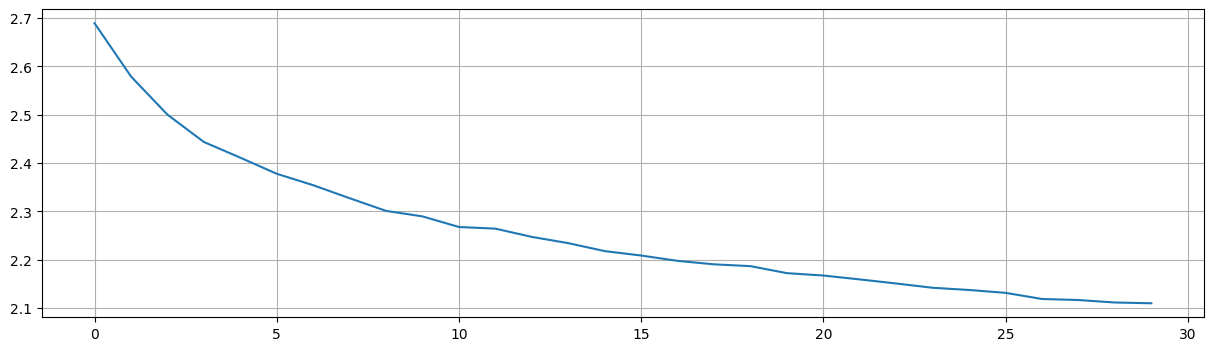

In [ ]:
### Try different learning rate and epochs
###  first multiclass classification model
nn = MLP([128,12, 10], [None,'relu','softmax'])
input_data = train_X
output_data = train_y

print(input_data.shape)
print(output_data.shape)

cross_entropy = nn.fit(input_data, output_data, learning_rate=0.00001, epochs=30, batch_size=5)
pl.figure(figsize=(15,4))
pl.plot(cross_entropy)
pl.grid()

(128, 12)
(12,)
(12, 10)
(10,)
(50000, 128)
(50000, 10)


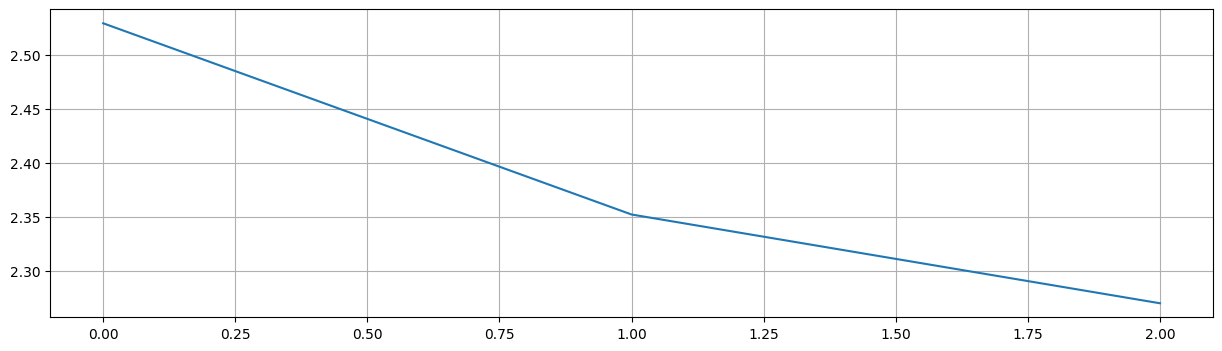

In [ ]:
### Try different learning rate and epochs
###  first multiclass classification model
nn2 = MLP([128,12, 10], [None,'relu','softmax'])
input_data = train_X
output_data = train_y

print(input_data.shape)
print(output_data.shape)

cross_entropy2 = nn2.fit(input_data, output_data, learning_rate=0.00001, epochs=3, batch_size=1)
pl.figure(figsize=(15,4))
pl.plot(cross_entropy2)
pl.grid()

(128, 12)
(12,)
(12, 10)
(10,)
(50000, 128)
(50000, 10)


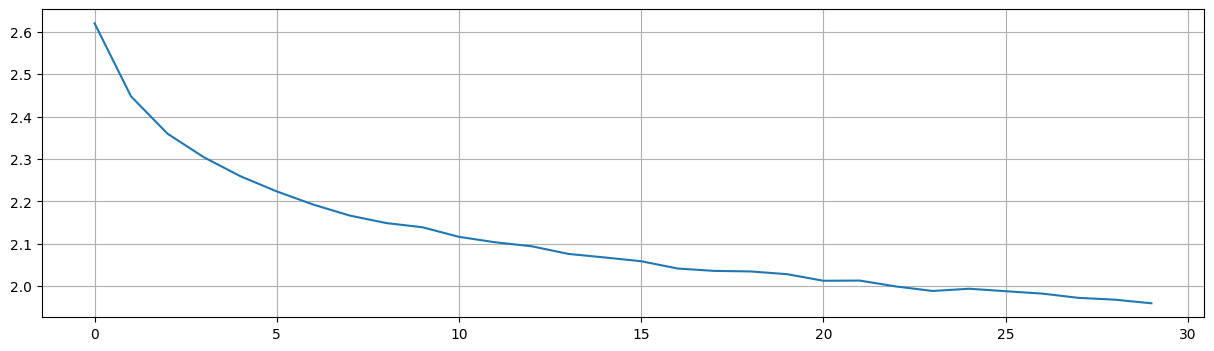

In [ ]:
### Try different learning rate and epochs
###  first multiclass classification model
nn3 = MLP([128,12, 10], [None,'relu','softmax'])
input_data = train_X
output_data = train_y

print(input_data.shape)
print(output_data.shape)

cross_entropy3 = nn3.fit(input_data, output_data, learning_rate=0.00001, epochs=30, batch_size=5, momentum_gamma = 0.7)
pl.figure(figsize=(15,4))
pl.plot(cross_entropy3)
pl.grid()

#### Plot loss in epochs
We can visualize the loss change during the training process, to under how we can the network. As we can see, the loss staies at the large level at the beginning, but drop quickly within the training. A small loss value indicate a well-trained network.

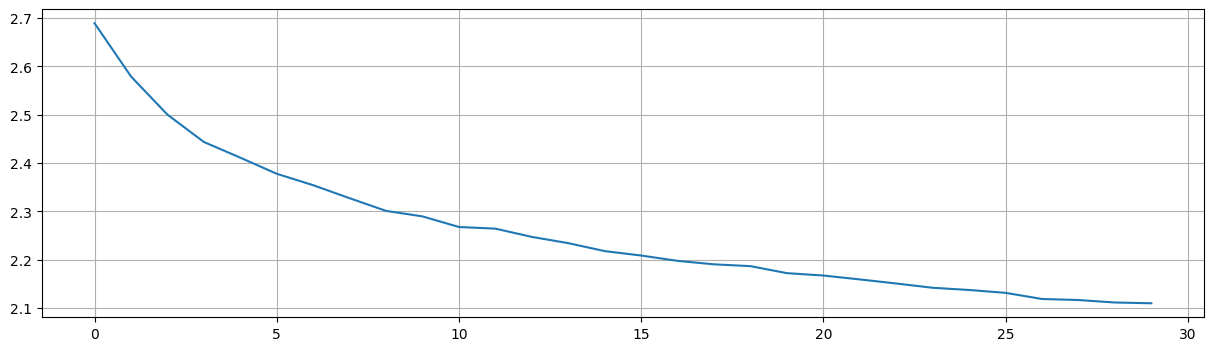

In [ ]:
pl.figure(figsize=(15,4))
pl.plot(cross_entropy)
pl.grid()

## Testing